### Accessing content in your drive


In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### AIM ### 

Find Rpeaks location in ECG </br>
Look at the image: https://drive.google.com/file/d/1_6IDe8FYJia-UOFVEvKsxergN6A1IOw4/view?usp=sharing

### Navigate to the location of folder ###

In [2]:
# import os
# os.chdir('drive/My Drive/RPNet Model/Webinar_coding_session')

### Importing required modules

In [1]:
### Importing basic libraries
import scipy.io
import numpy as np
import torch
from scipy import signal
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import random
import pandas as pd
import scipy
import pickle
import sklearn
from sklearn.preprocessing import MinMaxScaler
import warnings
import math
import csv
from tqdm.notebook import tqdm

from scipy.signal import butter, lfilter, lfilter_zi
from pylab import plot, show, title, xlabel, ylabel, subplot

### Importing torch related libraries
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable   
import torch.optim as optim
from torch.optim import lr_scheduler
import datetime
import os

### Importing Custom Libraries
from network import IncUNet

# Preprocessing #

### Navigate to the folder containing the model and data

In [2]:
data_path = "original_data/data"
reference_path = "original_data/ref"

### Loading from the Mat file

In [4]:
# run subset
# count = 0 
# patient_info = []
# for files in sorted(os.listdir(data_path)):
#     count += 1
#     patient_info.append(scipy.io.loadmat(os.path.join(data_path,files)))
#     if count == 20:
#       break
    
### Entire thing can be run in a single line
patient_info = [scipy.io.loadmat(os.path.join(data_path,files)) for files in tqdm(sorted(os.listdir(data_path)))]


  0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
# run subset
# count = 0 
# patient_reference = []
# for files in sorted(os.listdir(reference_path)):
#     count += 1
#     patient_reference.append(scipy.io.loadmat(os.path.join(reference_path,files)))
#     if count == 20:
#       break

### Entire thing can be run in a single line
patient_reference = [scipy.io.loadmat(os.path.join(reference_path,files)) for files in tqdm(sorted(os.listdir(reference_path)))]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
print(len(patient_info))
print(len(patient_reference))

2000
2000


### To obtain the patient's ECG Record ###

In [7]:
patient_ecg = np.asarray( [patient_info[i]['ecg'] for i in tqdm(range(0,len(patient_info)))] )
print("Shape of the ECG record",patient_ecg.shape)
patient_ecg = patient_ecg[:,:,0]

  0%|          | 0/2000 [00:00<?, ?it/s]

Shape of the ECG record (2000, 5000, 1)



### Normalizing Patient ECG

In [8]:
scaler = sklearn.preprocessing.StandardScaler()
patient_ecg = scaler.fit_transform(patient_ecg.transpose()).transpose()

### To obtain the Reference Value ###

In [9]:
patient_ref = []
for j in range(0,len(patient_reference)):
    if(patient_reference[j]['R_peak'].shape[0] == 1):
        patient_ref.append(patient_reference[j]['R_peak'][0].ravel().astype(np.float16))
    else:
        patient_ref.append(patient_reference[j]['R_peak'].ravel().astype(np.float16))

### Determining no of QRS complexes in windows

In [10]:
count = np.zeros((5,1))
for i in range(len(patient_ref)-64):
    if(len(patient_ref[i]) <= 10):
        count[0] += 1 
    elif (len(patient_ref[i]) > 10 and len(patient_ref[i]) <= 20):
        count[1] += 1
    elif (len(patient_ref[i]) > 20 and len(patient_ref[i]) <= 30):
        count[2] += 1
    elif (len(patient_ref[i])>30 and len(patient_ref[i])<=40):
        count[3] += 1
    elif (len(patient_ref[i])>40 and len(patient_ref[i])<=50):
        count[4] += 1

### Distance Transform- Obtaining ground truth

In [11]:
distance_transform = []
for i in tqdm(range(len(patient_ref))):
    prev_qrs = patient_ref[i][0]
    next_qrs = patient_ref[i][1]
    dist_tran = np.zeros(patient_ecg.shape[1])
    beat_count = 1
    for j in range(len(dist_tran)):
        threshold = (prev_qrs + next_qrs)/2   
        if(j < threshold):
            dist_tran[j] = int(abs(j - prev_qrs))/250
        elif(j >= threshold): 
            dist_tran[j] = int(abs(j - next_qrs))/250
        if(j == next_qrs and beat_count != len(patient_ref[i])-1): ## -2 instead of -1 because we are incrementing the beat in the loop
            beat_count += 1 
            prev_qrs = next_qrs
            next_qrs = patient_ref[i][beat_count]
    distance_transform.append(dist_tran)
distance_transform = np.asarray(distance_transform)
scaler = MinMaxScaler(feature_range = (0,1))
distance_transform =  np.transpose(scaler.fit_transform(distance_transform.transpose())) 

  0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
dist_transform = torch.Tensor(distance_transform)
dist_transform = dist_transform.view(dist_transform.shape[0],1,dist_transform.shape[1])
print(dist_transform.shape)

torch.Size([2000, 1, 5000])


In [22]:
BATCH_SIZE = 32 # 64 is too large for 8GB gpu
C,H,W = 1,1,5000
learn_rate = 0.05
num_epochs = 3 # originally 20

In [23]:
print(patient_ecg.shape)
print(dist_transform.shape)

# train_test_split = 15
train_test_split = 1936

print("Train Dataset")
patient_ecg_t = torch.from_numpy(patient_ecg).float()
patient_ecg_train = patient_ecg_t[:train_test_split,:]
patient_ecg_train = patient_ecg_train.view((patient_ecg_train.shape[0],1,patient_ecg_train.shape[1]))
dist_transform_train = dist_transform[:train_test_split,0,:]
dist_transform_train = dist_transform_train.view(dist_transform_train.shape[0],1,dist_transform_train.shape[1])
print("Shape of input:",patient_ecg_train.shape)
print("Shape of ground truth:",dist_transform_train.shape)
patient_ecg_tl = TensorDataset(patient_ecg_train,dist_transform_train)
trainloader = DataLoader(patient_ecg_tl, batch_size=BATCH_SIZE, shuffle = True)

print("Test Dataset")
patient_ecg_t_test = patient_ecg_t[train_test_split:,:]
patient_ecg_t_test = patient_ecg_t_test.view((patient_ecg_t_test.shape[0],1,patient_ecg_t_test.shape[1]))
dist_transform_test = dist_transform[train_test_split:,:]
print("Shape of input:",patient_ecg_t_test.shape)
print("Shape of ground truth:",dist_transform_test.shape)
patient_ecg_tl_test = TensorDataset(patient_ecg_t_test,dist_transform_test)
testloader = DataLoader(patient_ecg_tl_test, batch_size=BATCH_SIZE)

torch.save(patient_ecg_train, 'train.pt')
torch.save(patient_ecg_t_test, 'test.pt')
torch.save(dist_transform_train, 'dist_transform_train.pt')
torch.save(dist_transform_test, 'dist_transform_test.pt')

(2000, 5000)
torch.Size([2000, 1, 5000])
Train Dataset
Shape of input: torch.Size([1936, 1, 5000])
Shape of ground truth: torch.Size([1936, 1, 5000])
Test Dataset
Shape of input: torch.Size([64, 1, 5000])
Shape of ground truth: torch.Size([64, 1, 5000])


# Train and Evaluate #

### Hyperparameters and Related parameters

### Loading data via the pt files

In [24]:
patient_ecg_train = torch.load('train.pt')
dist_transform_train = torch.load('dist_transform_train.pt')
patient_ecg_test = torch.load('test.pt')
dist_transform_test = torch.load('dist_transform_test.pt')

patient_ecg_train_td = TensorDataset(patient_ecg_train, dist_transform_train)
trainloader = DataLoader(patient_ecg_train_td, batch_size=BATCH_SIZE, shuffle = True)

patient_ecg_test_td = TensorDataset(patient_ecg_test, dist_transform_test)
testloader = DataLoader(patient_ecg_test_td, batch_size=BATCH_SIZE)

### Visualizing using Matplotlib

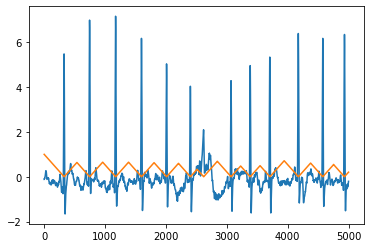

In [25]:
record_no = 18
plt.plot(patient_ecg_train[record_no,0,:].numpy())
plt.plot(dist_transform_train[record_no,0,:].numpy())

### Ensuring deterministicity through Random seeding


In [26]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
manualSeed = 4
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed) 

### Setting the optimizer and Loss function

In [27]:
model = IncUNet(in_shape = (C,H,W))
model.cuda()

optimizer = optim.Adam(model.parameters(), lr = learn_rate)# Try out weight decay , 
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[90,190,450], gamma=0.1)

criterion = nn.SmoothL1Loss()

### Initializing Tensorboard ###

In [28]:
### Using datetime to capture date time and write details into a text file
date_time = str(datetime.datetime.now())
date = date_time[:10]
start_time = date_time[11:19].replace(":","_")
model_path = "saved_model/" + date + "__" + start_time + "/" 
if not(os.path.exists('saved_model')): 
  os.mkdir('saved_model')
os.mkdir(model_path)
log_file = './' + model_path + 'logfile.txt'
log_data = open(log_file,'w+')
settings = ' The Settings of the model are: Epoch:%d, LR:%f, BATCH_SIZE:%d Seed:%d\n'%(num_epochs,learn_rate,BATCH_SIZE,manualSeed)
log_data.write(settings) 

75

### Training ###

In [29]:
epoch_loss = []
min_test_loss = 1000 ### Set a very high number

best_model_name = ""

for epoch in tqdm(range(num_epochs)):
    print ('-'*40)
    model.train()
    print ('Epoch {}/{}'.format(epoch+1,num_epochs))
    print ('-'*10)
    net_loss = 0
    
    for step,(x,y) in enumerate(trainloader):
        
        print("Step no: {}/{}".format(step+1, len(trainloader)))
        x,y = x.cuda(),y.cuda()
        y_predict = model(x) 
        
        ### Loss computation and Optimization ###
        loss = criterion(y,y_predict)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        net_loss += loss
        
    net_loss = net_loss/ (step + 1)
    
    ### Logging ###
    settings = "\nEpoch:{},Loss:{}".format(epoch,net_loss)
    log_data.write(settings)
    if(epoch == num_epochs - 1):
        log_data.close()
    
    print("Net loss is:", net_loss)
    epoch_loss.append(net_loss.data)
    
    scheduler.step()

    ### Evaluation and saving best model ###    
    if epoch % 10 == 0:
        print ('-'*40)
        print("..........Evaluation..........")
        print("Epoch No is:", epoch)
        model.eval()
    
        with torch.no_grad():
          net_test_loss = 0 
          for step,(x,y) in enumerate(testloader): ### Use trainloader for AK2-11 ###
              x,y = Variable(x.cuda()),Variable(y.cuda())
              y_predict_test = model(x)
                           
              test_loss = criterion(y_predict_test,y)                
              net_test_loss += test_loss                 
            
          net_test_loss /= step + 1 
            
        ### Saving the best model based on the Minimum Loss
        if net_test_loss < min_test_loss:
          min_test_loss = net_test_loss
          print("..........Saving the model..........")
          torch.save(model.state_dict(),model_path+'Epoch'+str(epoch)+'.pt')
          best_model_name = 'Epoch'+str(epoch)+'.pt'


  0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------
Epoch 1/3
----------
Step no: 1/61
Step no: 2/61
Step no: 3/61
Step no: 4/61
Step no: 5/61
Step no: 6/61
Step no: 7/61
Step no: 8/61
Step no: 9/61
Step no: 10/61
Step no: 11/61
Step no: 12/61
Step no: 13/61
Step no: 14/61
Step no: 15/61
Step no: 16/61
Step no: 17/61
Step no: 18/61
Step no: 19/61
Step no: 20/61
Step no: 21/61
Step no: 22/61
Step no: 23/61
Step no: 24/61
Step no: 25/61
Step no: 26/61
Step no: 27/61
Step no: 28/61
Step no: 29/61
Step no: 30/61
Step no: 31/61
Step no: 32/61
Step no: 33/61
Step no: 34/61
Step no: 35/61
Step no: 36/61
Step no: 37/61
Step no: 38/61
Step no: 39/61
Step no: 40/61
Step no: 41/61
Step no: 42/61
Step no: 43/61
Step no: 44/61
Step no: 45/61
Step no: 46/61
Step no: 47/61
Step no: 48/61
Step no: 49/61
Step no: 50/61
Step no: 51/61
Step no: 52/61
Step no: 53/61
Step no: 54/61
Step no: 55/61
Step no: 56/61
Step no: 57/61
Step no: 58/61
Step no: 59/61
Step no: 60/61
Step no: 61/61
Net loss is: tensor(0.3638, devi

### Evaluation



In [30]:
# SAVED_MODEL_PATH = "model.pt"
# model.load_state_dict(torch.load(SAVED_MODEL_PATH))
model.load_state_dict(torch.load(model_path +  best_model_name))

<All keys matched successfully>

In [31]:
model.eval()
y_pred_array = []
ecg = []

with torch.no_grad():
  net_test_loss = 0 
  for step,(x,y) in enumerate(testloader): 
      
      x,y = x.cuda(),y.cuda()
      y_predict_test = model(x)
                   
      test_loss = criterion(y_predict_test,y)                
      net_test_loss += test_loss   
      print('Step: {}, Loss: {} '.format(step,net_test_loss))

      ecg.append(x.cpu().numpy())
      y_pred_array.append(y_predict_test[:,0,:].cpu().numpy())

Step: 0, Loss: 0.024278057739138603 
Step: 1, Loss: 0.05865020304918289 


### Post Processing ###

In [32]:
batch_no = 0
y_pred_array = np.asarray(y_pred_array[batch_no])
ecg = np.asarray(ecg[batch_no])[:,0,:]

peak_locs = []
for i in range(y_pred_array.shape[0]):
    peak_locs.append(scipy.signal.find_peaks(-y_pred_array[i,:],distance = 90,height = -0.2,prominence = 0.035)[0])

### Getting the amplitude values at valley location. 
y_roll_valleys = []
y = []
for j in range(len(peak_locs)):
    y = [ecg[j,i] for i in peak_locs[j]]
    y_roll_valleys.append(y)

### Plotting output ###

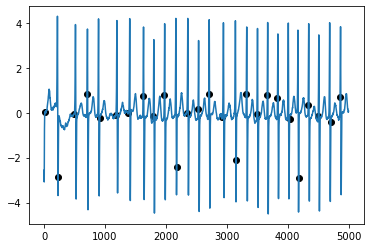

In [39]:
record_no = 11
plt.plot(ecg[record_no,:])
plt.scatter(peak_locs[record_no], y_roll_valleys[record_no], c="k")